# El niño efects?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
import os
import seaborn as sns
from shapely.ops import nearest_points

## cargue los datos

In [2]:
npfile   = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz')

In [3]:
syr      = npfile.f.dtw_syr
condyr   = npfile.f.dtw_condyr
s_nmax_yr= npfile.f.dtw_s_nmax_yr
nmax_yr  = npfile.f.dtw_nmax_yr
vyr      = npfile.f.dtw_vyr
tyr      = npfile.f.dtw_tyr
lat      = npfile.f.lat
lon      = npfile.f.lon
interc_t = npfile.f.dtw_interc_t
slop_t   = npfile.f.dtw_slop_t

ndat = len(condyr)
ngood = np.count_nonzero(condyr==1)

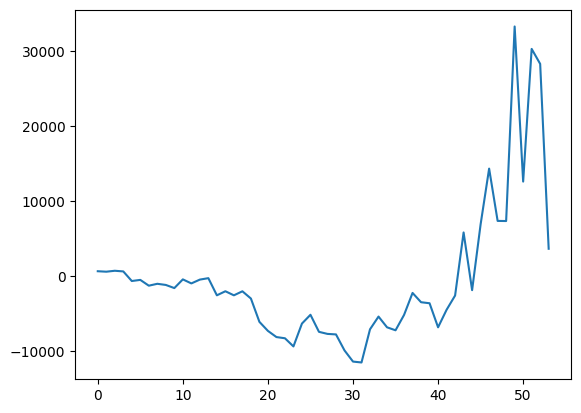

In [4]:
t_all = tyr[1,:]
tmin  = np.min(t_all)-1
tmax  = np.max(t_all)+1

vmat   = np.zeros((len(t_all),ngood))
vstack = np.zeros(len(t_all))
vstack[:] = np.nan
vmat[:]   = np.nan

ncnt = -1
for i in range(ndat):
    if (condyr[i]==0):
        continue
    ncnt = ncnt + 1
    # Puntos válidos
    #print(syr[i], condyr[i])
    #print(s_nmax_yr[i],nmax_yr[i])
    i0 = s_nmax_yr[i]
    i1 = i0+nmax_yr[i]
    t  = t_all[i0:i1]
    pline = t*slop_t[i] + interc_t[i]

    res   = vyr[i,i0:i1]-pline
    res = np.nan_to_num(res)
    vstack[i0:i1] = np.where(np.isnan(vstack[i0:i1]), res, vstack[i0:i1] + res)
    vmat[i0:i1,ncnt] = res

    continue
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(t_all,vyr[i,:],'lightgray')
    ax1.plot(t,vyr[i,i0:i1],'k')
    ax1.plot(t,pline)
    ax1.set_xlim(tmin,tmax)
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(t,res) 
    ax2.plot(t_all,vstack,'lightgray')
    ax2.set_xlim(tmin,tmax)

fig = plt.figure()
plt.plot(t_all,vstack)
plt.show()

(-5.0, 5.0)

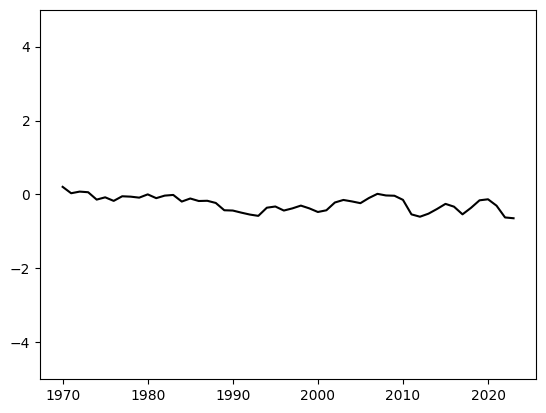

In [5]:
N = ngood
#plt.plot(vmat[:,0:N],'.')
plt.plot(t_all+1970,np.nanmedian(vmat[:,0:N],axis=1),'k-')
plt.ylim(-5,5)

In [8]:
### Por regiones geográficas

In [6]:
def asignar_region(lat, lon):
    """Devuelve el nombre de la región de Australia según lat/lon."""
    if lon > 129 and lon < 141 and lat < -25:  
        return "South Australia"
    elif lon > 129 and lat >= -25:  
        return "Northern Territory"
    elif lon > 138 and lat < -28:  
        return "Victoria"
    elif lon > 140 and lat < -26:  
        return "New South Wales"
    elif lon > 138 and lon < 154 and lat >= -28:  
        return "Queensland"
    elif lon > 112 and lon < 129:  
        return "Western Australia"
    elif lat < -39.2 and lon > 144 and lon < 149:  
        return "Tasmania"
    else:
        return "Unknown"

In [7]:
# Usar listas para acumular valores antes de convertir a matriz
residuales_por_region = defaultdict(list)

# Encontrar la longitud máxima de todas las series (para padding con NaN)
max_length = len(t_all)

for i in range(ndat):
    if condyr[i] == 0:
        continue

    region = asignar_region(lat[i], lon[i])  # Determinar la región de cada estación

    if region != "Unknown":
        i0, i1 = s_nmax_yr[i], s_nmax_yr[i] + nmax_yr[i]
        
        if i1 > max_length:  # Asegurar que no exceda el índice
            i1 = max_length

        res = vyr[i, i0:i1] - (t_all[i0:i1] * slop_t[i] + interc_t[i])
        res = np.nan_to_num(res)  # Convertir NaN a 0 para evitar propagación

        # Crear un array de NaN con el tamaño máximo
        res_padded = np.full(max_length, np.nan)
        res_padded[i0:i1] = res  # Insertar los valores en el rango correcto

        # Agregar la serie de residuales a la lista de la región
        residuales_por_region[region].append(res_padded)

# Convertir listas en matrices 2D asegurando que las dimensiones coincidan
for region in residuales_por_region:
    residuales_por_region[region] = np.array(residuales_por_region[region]).T  # Transponer para (tiempo, estaciones)

In [8]:
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\regiones'
os.makedirs(output_folder, exist_ok=True)  # Crear la carpeta si no existe

for region, valores in residuales_por_region.items():
    valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones
    
    plt.figure(figsize=(10, 5))
    plt.plot(t_all + 1970, valores_median, 'k-')  # Línea negra

    plt.xlabel("Año")
    plt.ylabel("Mediana de los Residuales")
    plt.title(f"Mediana de Residuales en {region}")
    plt.ylim(-5, 5)
    
    # Definir la ruta del archivo
    filename = os.path.join(output_folder, f"residuales_{region.replace(' ', '_')}.png")
    
    # Guardar la imagen
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Cerrar la figura para liberar memoria

In [9]:
plt.figure(figsize=(10, 5))

for region, valores in residuales_por_region.items():
    plt.plot(t_all + 1970, valores, label=region)

plt.legend()
plt.xlabel("Año")
plt.title("Suma de Residuales por Región en Australia")
plt.ylim(-5, 5)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 825x277630 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x500 with 1 Axes>

In [14]:
valores = valores[:, np.newaxis]  # Convertir en 2D si es necesario

In [15]:
### Residuales por cuencas hidrogeológicas

In [16]:
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\australia_aquifers.shp'
cuencas = gpd.read_file(shp_path)

In [17]:
lat = np.array(lat).ravel()  # Asegurar que sea 1D
lon = np.array(lon).ravel()  # Asegurar que sea 1D

In [18]:
gdf_stations = gpd.GeoDataFrame(pd.DataFrame({'lat': lat, 'lon': lon}), 
                                geometry=gpd.points_from_xy(lon, lat),
                                crs="EPSG:4326")  # Coordenadas geográficas

# Asegurar que las cuencas tengan el mismo sistema de referencia
cuencas = cuencas.to_crs(gdf_stations.crs)

# Realizar la unión espacial para asignar la cuenca a cada estación
gdf_stations = gdf_stations.sjoin(cuencas[['geometry', 'Broader']], how='left')

# Revisar los resultados
print(gdf_stations[['lat', 'lon', 'Broader']].head())

         lat         lon               Broader
0 -33.437086  148.222974                     -
1 -30.094821  149.562252  Great Artesian Basin
2 -31.519814  150.652527                     -
3 -34.479717  144.299661          Murray Basin
4 -35.955811  145.964653          Murray Basin


In [19]:
# Usar listas para acumular valores antes de convertir a matriz
residuales_por_cuenca = defaultdict(list)

# Encontrar la longitud máxima de todas las series (para padding con NaN)
max_length = len(t_all)

for i in range(ndat):
    if condyr[i] == 0:
        continue

    cuenca = gdf_stations.loc[i, 'Broader']  # Obtener la cuenca de la estación

    if pd.notna(cuenca):  # Solo considerar estaciones con cuenca asignada
        i0, i1 = s_nmax_yr[i], s_nmax_yr[i] + nmax_yr[i]

        if i1 > max_length:  # Asegurar que no exceda el índice
            i1 = max_length

        res = vyr[i, i0:i1] - (t_all[i0:i1] * slop_t[i] + interc_t[i])
        res = np.nan_to_num(res)  # Convertir NaN a 0 para evitar propagación

        # Crear un array de NaN con el tamaño máximo
        res_padded = np.full(max_length, np.nan)
        res_padded[i0:i1] = res  # Insertar los valores en el rango correcto

        # Agregar la serie de residuales a la lista de la cuenca
        residuales_por_cuenca[cuenca].append(res_padded)

# Convertir listas en matrices 2D asegurando que las dimensiones coincidan
for cuenca in residuales_por_cuenca:
    residuales_por_cuenca[cuenca] = np.array(residuales_por_cuenca[cuenca]).T  # Transponer para (tiempo, estaciones)

In [20]:
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\cuencas'
os.makedirs(output_folder, exist_ok=True)  # Crear la carpeta si no existe

for cuenca, valores in residuales_por_cuenca.items():
    valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones
    
    plt.figure(figsize=(10, 5))
    plt.plot(t_all + 1970, valores_median, 'k-')  # Línea negra

    plt.xlabel("Año")
    #plt.ylabel("Mediana de los Residuales")
    #plt.title(f"Mediana de Residuales en {cuenca}")
    plt.ylim(-10, 10)
    
    # Definir la ruta del archivo
    filename = os.path.join(output_folder, f"residuales_{cuenca.replace(' ', '_')}.png")
    
    # Guardar la imagen
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Cerrar la figura para liberar memoria

C:\Users\Andrea Fandiño P\AppData\Local\Temp\ipykernel_18804\1587189917.py:5: RuntimeWarning: All-NaN slice encountered
  valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones


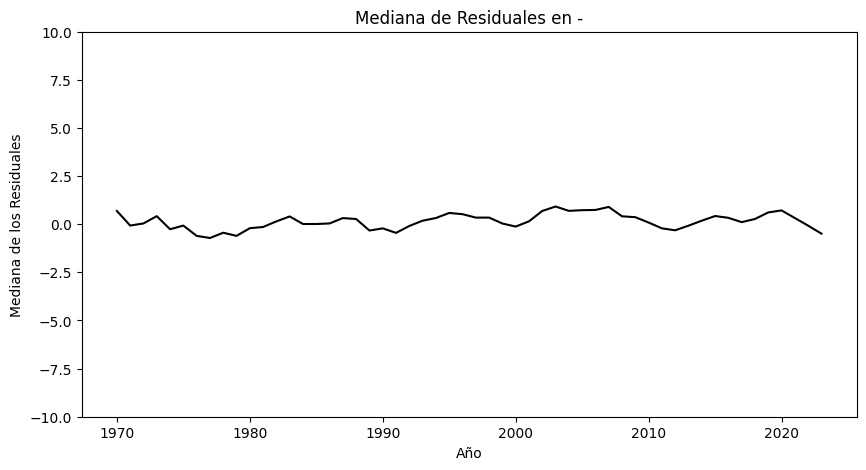

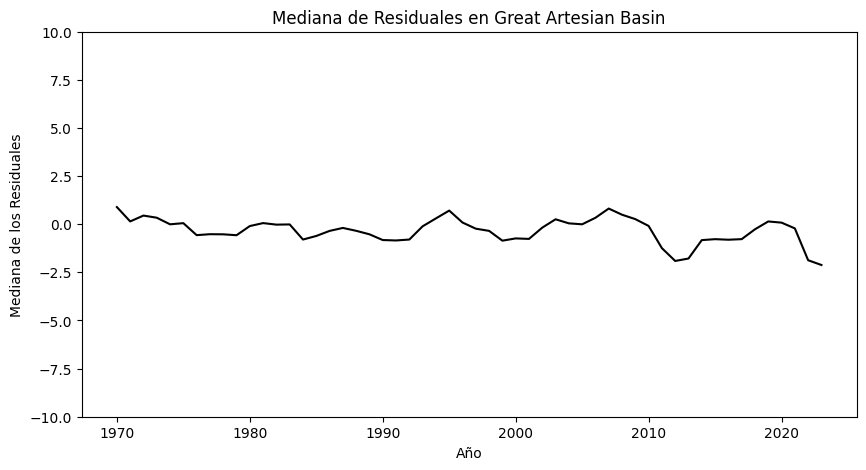

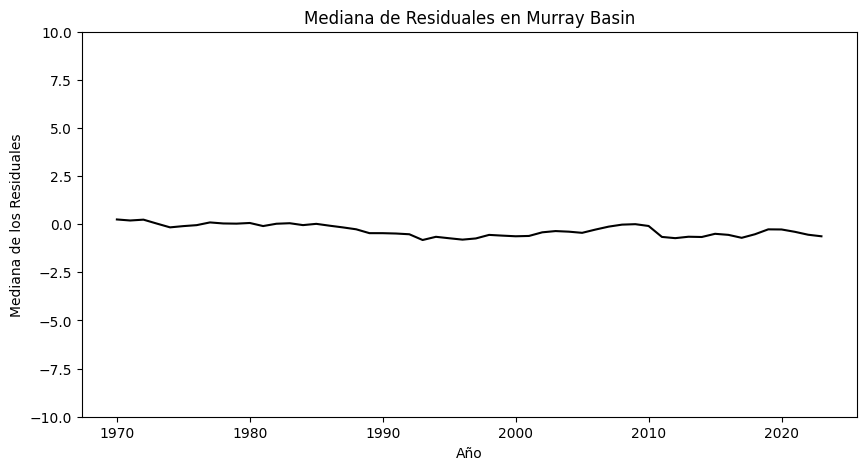

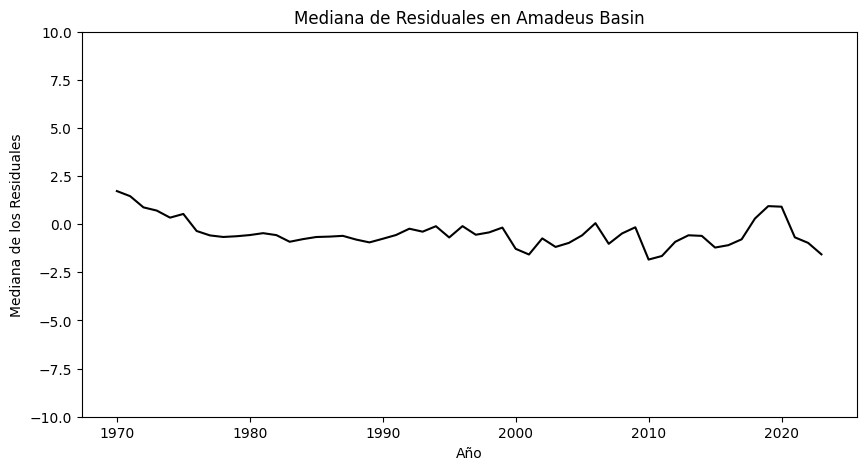

C:\Users\Andrea Fandiño P\AppData\Local\Temp\ipykernel_18804\1229264665.py:2: RuntimeWarning: All-NaN slice encountered
  valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones


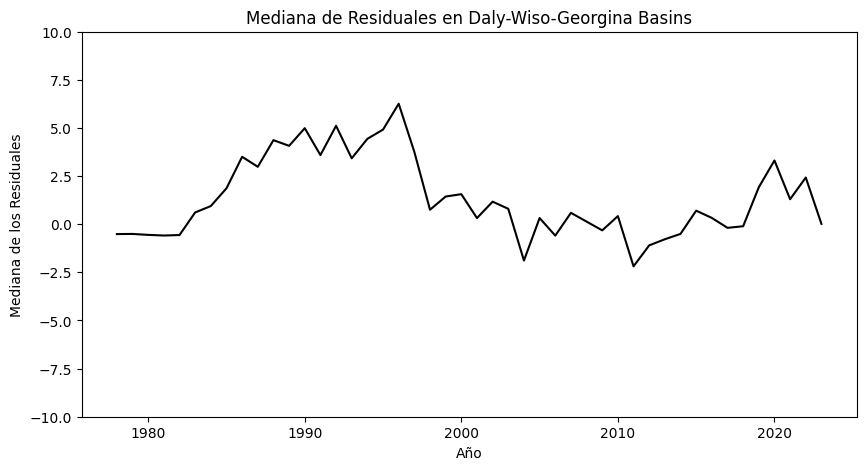

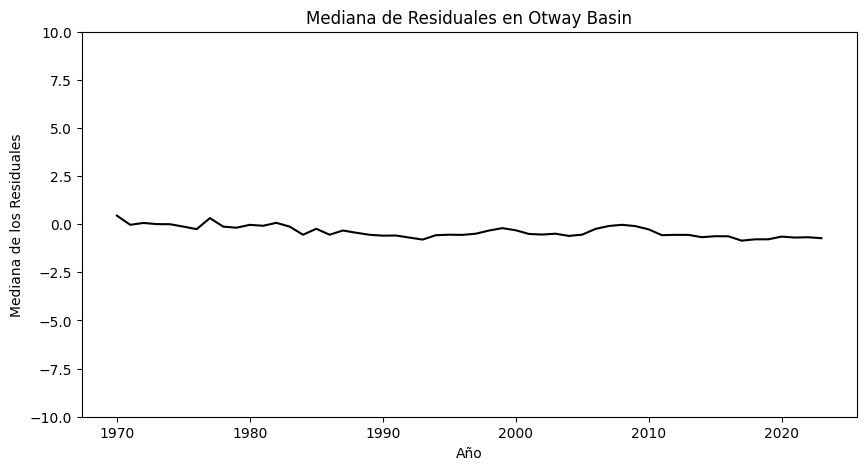

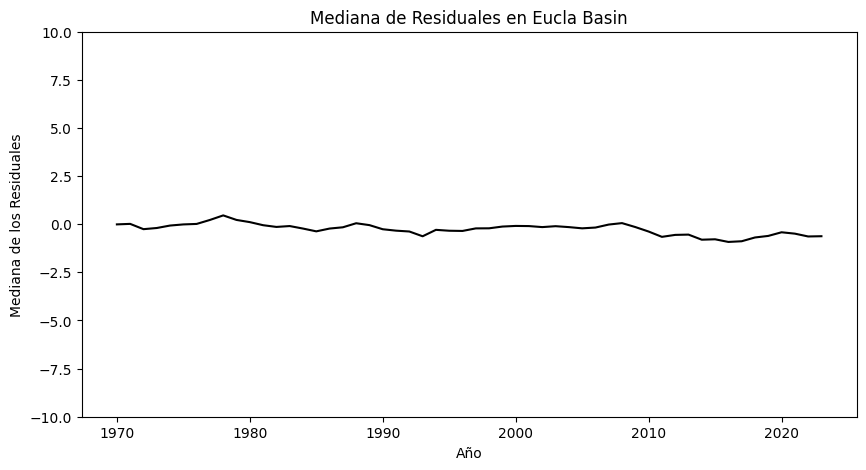

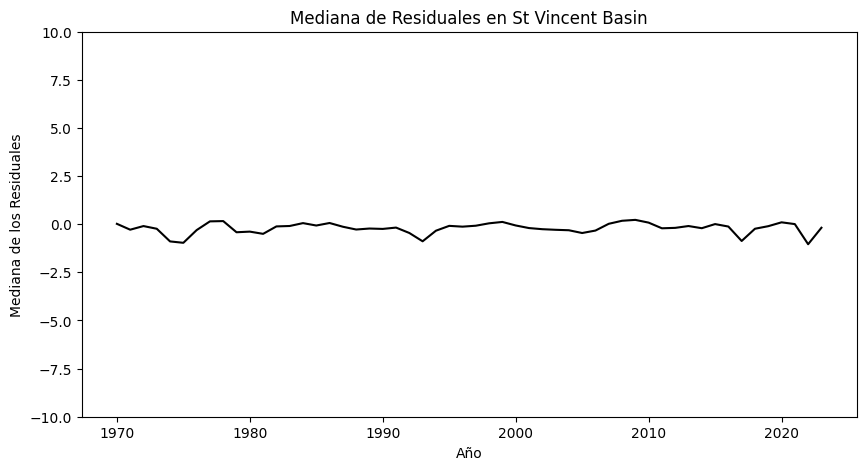

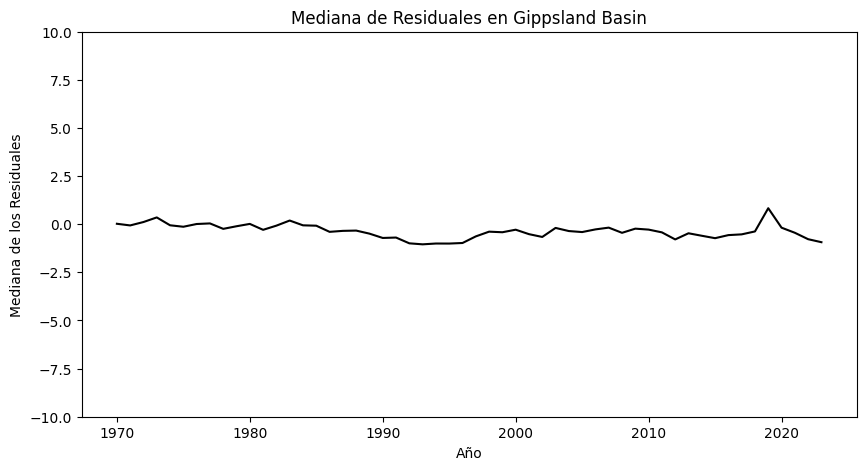

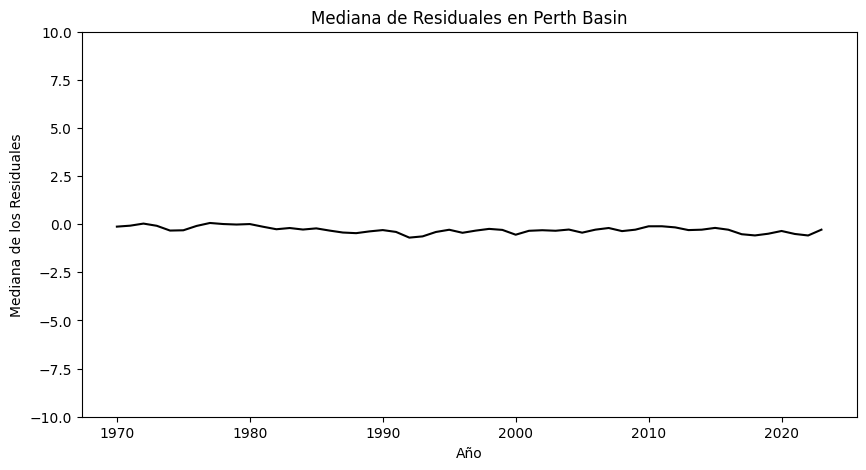

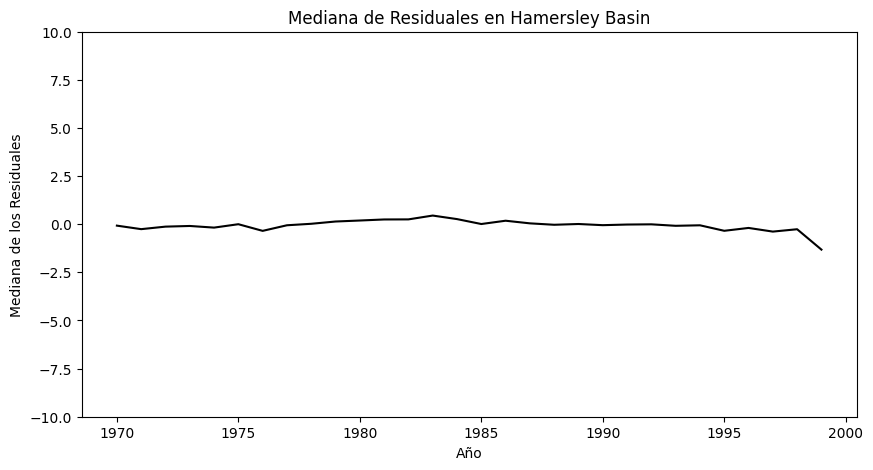

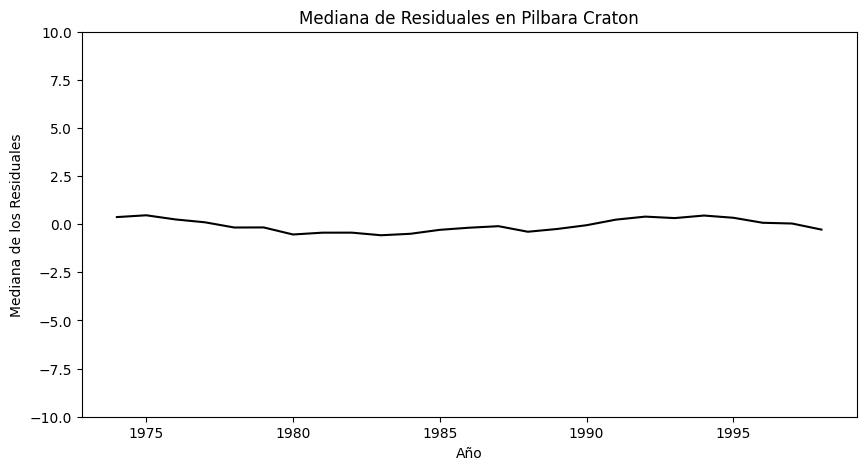

In [21]:
for cuenca, valores in residuales_por_cuenca.items():
    valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones
    
    plt.figure(figsize=(10, 5))
    plt.plot(t_all + 1970, valores_median, 'k-')  # Línea negra

    plt.xlabel("Año")
    plt.ylabel("Mediana de los Residuales")
    plt.title(f"Mediana de Residuales en {cuenca}")
    plt.ylim(-10, 10)
    
    plt.show()

In [22]:
### Cuencas por años 2000, 2010 y 2020:

In [23]:
# Años específicos que deseas analizar
years_of_interest = [2000, 2010, 2020]

# Crear la carpeta de salida si no existe
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\años'
os.makedirs(output_folder, exist_ok=True)

# Iterar sobre cada cuenca y sus valores de residuales
for cuenca, valores in residuales_por_cuenca.items():
    for year in years_of_interest:
        # Obtener el índice del año en `t_all`
        year_indices = np.where(t_all + 1970 == year)[0]
        
        # Verificar si el año existe en `t_all`
        if len(year_indices) == 0:
            print(f"Advertencia: El año {year} no se encuentra en `t_all` para la cuenca {cuenca}.")
            continue
        
        year_index = year_indices[0]  # Tomar el primer índice si hay múltiples
        
        # Filtrar las estaciones válidas (condyr == 1)
        valid_stations = np.where(condyr == 1)[0]
        
        # Asegurarse de que los índices de estaciones no excedan las dimensiones de `valores`
        valid_stations = valid_stations[valid_stations < valores.shape[1]]
        
        # Seleccionar los residuales para el año y estaciones válidas
        valores_selected = valores[year_index, valid_stations]
        
        # Contar el número de estaciones válidas (ngood)
        ngood = np.count_nonzero(~np.isnan(valores_selected))
        
        # Verificar si hay datos válidos
        if ngood == 0:
            print(f"Advertencia: No hay datos válidos para la cuenca {cuenca} en el año {year}.")
            continue
        
        # Calcular la suma de los residuales para las estaciones válidas
        suma_residuales = np.nansum(valores_selected)
        
        # Crear la figura
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, ngood + 1), valores_selected[~np.isnan(valores_selected)], 'k-', label=f'Residuales {year}')
        
        # Etiquetas y título
        plt.xlabel("Estación")
        plt.ylabel("Residuales")
        plt.title(f"Residuales en {cuenca} para el año {year} (Estaciones válidas: {ngood})")
        plt.legend()
        
        # Definir la ruta del archivo con el nombre de la cuenca y el año
        filename = os.path.join(output_folder, f"residuales_{cuenca.replace(' ', '_')}_{year}.png")
        
        # Guardar la imagen
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()

Advertencia: No hay datos válidos para la cuenca Hamersley Basin en el año 2000.
Advertencia: No hay datos válidos para la cuenca Hamersley Basin en el año 2010.
Advertencia: No hay datos válidos para la cuenca Hamersley Basin en el año 2020.
Advertencia: No hay datos válidos para la cuenca Pilbara Craton en el año 2000.
Advertencia: No hay datos válidos para la cuenca Pilbara Craton en el año 2010.
Advertencia: No hay datos válidos para la cuenca Pilbara Craton en el año 2020.


In [24]:
# Definir los años seleccionados (2000, 2010, 2020)
years_selected = [2000, 2010, 2020]

# Crear listas para almacenar los datos
cuenca_names = []
years_list = []
stations_count = []

# Iterar por cuenca y contar estaciones válidas por año
for cuenca, valores in residuales_por_cuenca.items():
    for year in years_selected:
        # Obtener el índice del año en `t_all`
        year_indices = np.where(t_all + 1970 == year)[0]
        
        # Verificar si el año existe en `t_all`
        if len(year_indices) == 0:
            print(f"Advertencia: El año {year} no se encuentra en `t_all` para la cuenca {cuenca}.")
            continue
        
        year_index = year_indices[0]  # Tomar el primer índice si hay múltiples
        
        # Filtrar las estaciones válidas (condyr == 1)
        valid_stations = np.where(condyr == 1)[0]
        
        # Asegurarse de que los índices de estaciones no excedan las dimensiones de `valores`
        valid_stations = valid_stations[valid_stations < valores.shape[1]]
        
        # Seleccionar los residuales para el año y estaciones válidas
        valores_selected = valores[year_index, valid_stations]
        
        # Contar cuántas estaciones tienen datos válidos (no NaN) para este año y cuenca
        count = np.count_nonzero(~np.isnan(valores_selected))
        
        # Almacenar los datos
        cuenca_names.append(cuenca)
        years_list.append(year)
        stations_count.append(count)

# Crear un DataFrame con la cantidad de estaciones usadas por cuenca y año
df_stations_summary = pd.DataFrame({
    "Cuenca": cuenca_names,
    "Año": years_list,
    "Estaciones Usadas": stations_count
})

# Mostrar la tabla en consola
print(df_stations_summary)

                       Cuenca   Año  Estaciones Usadas
0                           -  2000               1317
1                           -  2010               1234
2                           -  2020                971
3        Great Artesian Basin  2000                497
4        Great Artesian Basin  2010                478
5        Great Artesian Basin  2020                348
6                Murray Basin  2000               2126
7                Murray Basin  2010               1834
8                Murray Basin  2020                722
9               Amadeus Basin  2000                 80
10              Amadeus Basin  2010                 13
11              Amadeus Basin  2020                 11
12  Daly-Wiso-Georgina Basins  2000                 35
13  Daly-Wiso-Georgina Basins  2010                 40
14  Daly-Wiso-Georgina Basins  2020                 36
15                Otway Basin  2000                478
16                Otway Basin  2010                460
17        

### Residuales por grillas

In [26]:
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\grillas'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [27]:
# Límites de Australia (aproximados en latitud y longitud)
min_lat, max_lat = -44, -10
min_lon, max_lon = 112, 154
cell_size = 1.0  # Tamaño de la celda en grados

In [28]:
# Crear las coordenadas de la grilla
lat_edges = np.arange(min_lat, max_lat + cell_size, cell_size)
lon_edges = np.arange(min_lon, max_lon + cell_size, cell_size)

# Coordenadas centrales de cada celda
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

In [29]:
# Crear las celdas de la grilla
celdas = []
for i in range(len(lat_edges) - 1):
    for j in range(len(lon_edges) - 1):
        celdas.append(Polygon([
            (lon_edges[j], lat_edges[i]),
            (lon_edges[j + 1], lat_edges[i]),
            (lon_edges[j + 1], lat_edges[i + 1]),
            (lon_edges[j], lat_edges[i + 1]),
            (lon_edges[j], lat_edges[i])
        ]))

In [30]:
# Función para verificar si un punto está dentro de un polígono
def ptsinpoly(pflat, pflon, lat, lon):
    points = [Point(lon[k], lat[k]) for k in range(len(lat))]
    inside = [celda.contains(point) for point in points]
    return np.where(inside)[0]

In [31]:
# Iterar sobre las primeras 10 celdas
for idx, celda in enumerate(celdas[:10]):  # Solo las primeras 10 celdas
    # Extraer los vértices del polígono directamente
    pflat = np.array(celda.exterior.xy[1])  # Latitudes
    pflon = np.array(celda.exterior.xy[0])  # Longitudes

    # Verificar qué puntos están dentro de la celda
    indices_dentro = ptsinpoly(pflat, pflon, lat, lon)

    # Si hay puntos dentro de la celda, generar las imágenes
    if len(indices_dentro) > 0:
        # Inicializar listas para almacenar los datos de la celda
        residuales_celda = []
        tiempos_celda = []

        # Iterar sobre los puntos dentro de la celda
        for i in indices_dentro:
            if condyr[i] == 1:
                i0 = s_nmax_yr[i]
                i1 = i0 + nmax_yr[i]
                t = tyr[1, i0:i1]
                pline = t * slop_t[i] + interc_t[i]
                res = vyr[i, i0:i1] - pline
                res = np.nan_to_num(res)
                residuales_celda.extend(res)
                tiempos_celda.extend(t)

        # Si hay datos en la celda, generar la imagen combinada
        if len(residuales_celda) > 0:
            # Depuración: Imprimir información sobre los datos
            print(f"Celda {idx + 1}:")
            print(f"  - Número de residuales: {len(residuales_celda)}")
            print(f"  - Número de tiempos: {len(tiempos_celda)}")
            print(f"  - Rango de tiempos: {np.min(tiempos_celda)} a {np.max(tiempos_celda)}")
            print(f"  - Rango de residuales: {np.min(residuales_celda)} a {np.max(residuales_celda)}")

            # Calcular la mediana de los residuales por año
            años_unicos = np.unique(np.floor(tiempos_celda))  # Obtener años únicos
            medianas = []
            for año in años_unicos:
                mask = np.floor(tiempos_celda) == año
                medianas.append(np.median(np.array(residuales_celda)[mask]))

            # Depuración: Imprimir información sobre la mediana
            print(f"  - Número de años únicos: {len(años_unicos)}")
            print(f"  - Mediana de residuales: {medianas}")

            # Crear la figura combinada
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

            # Gráfica 1: Suma acumulada de residuales
            ax1.plot(tiempos_celda, residuales_celda, 'b-', label='Residuales')
            ax1.set_xlabel('Tiempo')
            ax1.set_ylabel('Residuales')
            ax1.set_title(f'Suma Acumulada de Residuales en Celda {idx + 1}')
            ax1.grid(True)
            ax1.legend()

            # Gráfica 2: Mediana de residuales
            ax2.plot(años_unicos, medianas, 'k-', marker='o', markersize=5, label='Mediana de Residuales')
            ax2.set_xlabel('Año')
            ax2.set_ylabel('Mediana de Residuales')
            ax2.set_title(f'Mediana de Residuales en Celda {idx + 1}')
            ax2.grid(True)
            ax2.legend()

            # Guardar la figura combinada
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'combined_celda_{idx + 1}.png'))
            plt.close()

print(f"Proceso completado. Imágenes combinadas generadas en la carpeta: {output_folder}")

Proceso completado. Imágenes combinadas generadas en la carpeta: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\grillas


### Boxplot

In [17]:
# 1. Filtrar estaciones con condición buena (condyr == 1)
good_mask = (condyr == 1).flatten()  # Asegurar que sea 1D
good_lat = np.asarray(lat)[good_mask].flatten()  # Convertir a array y aplanar
good_lon = np.asarray(lon)[good_mask].flatten()
good_syr = np.asarray(syr)[good_mask].flatten()

# 2. Asignar regiones a cada estación
regiones = np.array([asignar_region(lat, lon) for lat, lon in zip(good_lat, good_lon)])

# 3. Crear GeoDataFrame con las estaciones buenas
geometry = gpd.points_from_xy(good_lon, good_lat)  # Ahora debería funcionar
gdf_stations = gpd.GeoDataFrame({
    'lat': good_lat,
    'lon': good_lon,
    'syr': good_syr,
    'region': regiones
}, geometry=geometry, crs="EPSG:4326")

# 4. Cargar las cuencas y hacer el spatial join
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\australia_aquifers.shp'
cuencas = gpd.read_file(shp_path).to_crs(gdf_stations.crs)
gdf_stations = gdf_stations.sjoin(cuencas[['geometry', 'Broader']], how='left')

# 5. Eliminar datos desconocidos
gdf_stations = gdf_stations[
    (gdf_stations['region'] != 'Unknown') & 
    (~gdf_stations['Broader'].isna())
]

# 6. Preparar datos para boxplots
# Para regiones
regiones_ordenadas = sorted(gdf_stations['region'].unique())
data_regiones = [gdf_stations[gdf_stations['region'] == reg]['syr'].values for reg in regiones_ordenadas]

# Para cuencas (ordenadas por mediana)
cuencas_ordenadas = gdf_stations.groupby('Broader')['syr'].median().sort_values().index
data_cuencas = [gdf_stations[gdf_stations['Broader'] == cuenca]['syr'].values for cuenca in cuencas_ordenadas]

In [19]:
# Para el gráfico de regiones
plt.figure(figsize=(12, 6))
plt.boxplot(data_regiones, labels=regiones_ordenadas)
plt.title('Distribución del Nivel Freático por Región')
plt.ylabel('Nivel Freático (m)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('boxplot_regiones.png', dpi=300)
plt.close()  # Cierra la figura para liberar memoria

# Para el gráfico de cuencas
plt.figure(figsize=(14, 6))
plt.boxplot(data_cuencas, labels=cuencas_ordenadas)
plt.title('Distribución del Nivel Freático por Cuenca')
plt.ylabel('Nivel Freático (m)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('boxplot_cuencas.png', dpi=300)
plt.close()

C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_16164\4032426649.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_regiones, labels=regiones_ordenadas)
C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_16164\4032426649.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_cuencas, labels=cuencas_ordenadas)
